# Modelling

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, SVDPredictor, FastLogisticSVD
from RecData import RecData

## Data Preprocessing

In [2]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
629351,12210,True,240
116928,22380,True,240
1418125,239140,True,240
236273,251570,True,240
87206,270880,True,240


In [3]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [4]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs
    
print("Creating splits...")
train_data, val, test = rec_data.leave_k_out_split(k=1)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 0
Done creating splits.


In [5]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [6]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [7]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

Epoch 0/Training error: 0.4501800428743795/Validation error: 0.44851722077667716/Time: 10.55 seconds
Epoch 1/Training error: 0.43297705055879115/Validation error: 0.43391371982559945/Time: 7.33 seconds
Epoch 2/Training error: 0.4230348249332996/Validation error: 0.42613175949096516/Time: 7.54 seconds
Epoch 3/Training error: 0.4155286349584029/Validation error: 0.4203710742339434/Time: 7.26 seconds
Epoch 4/Training error: 0.40927389061942926/Validation error: 0.4154554539913261/Time: 7.58 seconds
Epoch 5/Training error: 0.4038622027733717/Validation error: 0.41146643307584907/Time: 7.77 seconds
Epoch 6/Training error: 0.39903084081263546/Validation error: 0.4076393778083332/Time: 7.64 seconds
Epoch 7/Training error: 0.3947531127557591/Validation error: 0.4045028177508419/Time: 7.48 seconds
Epoch 8/Training error: 0.3908362825110755/Validation error: 0.40146682666734085/Time: 7.37 seconds
Epoch 9/Training error: 0.3872731829958809/Validation error: 0.39872863560256233/Time: 7.2 seconds
E

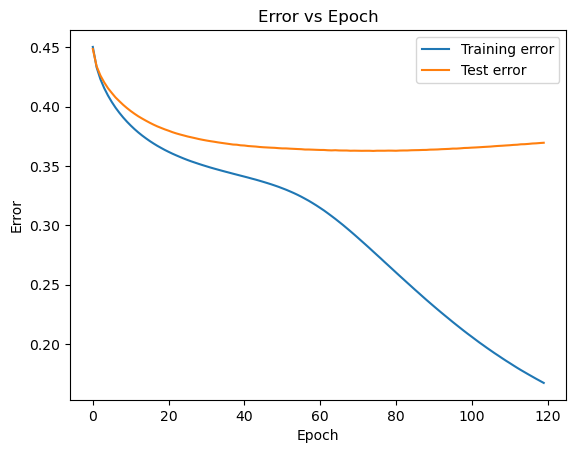

Test rmse 0.34022703167586205


In [8]:
# for pruned, epoch: 30, lr:0.01, reg:0.02, k=50

EPOCHS = 120

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=80, 
    learning_rate=0.01, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We can now continue to train if we believe the model is still underfitting.

In [39]:
svd_predictor.continue_fit(20, early_stop=False)

Epoch 0/Training error: 0.19053590656505803/Validation error: 0.37349245980175527/Time: 5.04 seconds
Epoch 1/Training error: 0.18825316930678915/Validation error: 0.3736884722884243/Time: 5.21 seconds
Epoch 2/Training error: 0.18598803402106873/Validation error: 0.37389827069872345/Time: 6.0 seconds
Epoch 3/Training error: 0.1838064664534095/Validation error: 0.3741446984797393/Time: 5.4 seconds
Epoch 4/Training error: 0.18163851772263095/Validation error: 0.37435329022300556/Time: 5.28 seconds
Epoch 5/Training error: 0.179443643887193/Validation error: 0.37458203290752035/Time: 4.98 seconds
Epoch 6/Training error: 0.1773410008503614/Validation error: 0.3747880386474543/Time: 5.47 seconds
Epoch 7/Training error: 0.17528116614041456/Validation error: 0.3749259008829289/Time: 5.31 seconds
Epoch 8/Training error: 0.17323795068445305/Validation error: 0.3752120742708525/Time: 5.36 seconds
Epoch 9/Training error: 0.1712096419295989/Validation error: 0.3754584724717603/Time: 5.23 seconds
Epo

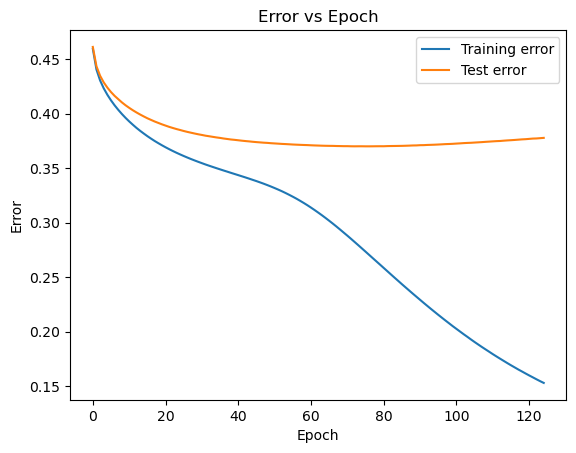

Test rmse 0.3437800582826854


In [40]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [9]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 0
Upto row 200
Upto row 400
Upto row 600
Upto row 800
Upto row 1000
Upto row 1200
Upto row 1400
Upto row 1600
Upto row 1800
Upto row 2000
Upto row 2200
Done computing similarities in 440.3786623477936 seconds


## Saving the model

In [51]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [4]:
with open('saved_models/2023-7-7-14-7-26_0-3402.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

In [19]:
train_data.search_title('stardew')

[('Stardew Valley', 500)]

In [20]:
top = svd_predictor.items_knn([(500, 1)])
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.5324245057124044, 'Arcanum: Of Steamworks and Magick Obscura'),
 (0.5225535508934316, 'Touhou Kikeijuu ~ Wily Beast and Weakest Creature.'),
 (0.5220047634637819, 'Heavenly Bodies'),
 (0.5130406512769492, 'Battle Chef Brigade Deluxe'),
 (0.4984954658015166,
  'Warhammer® 40000: Dawn of War® - Game of the Year Edition'),
 (0.4955127274505614, 'Grim Dawn'),
 (0.4616421396845921, 'Outer Wilds'),
 (0.4418063087928962, 'Noita'),
 (0.4400092455558826, 'Crypt of the NecroDancer'),
 (0.43789965452607804, "Shantae and the Pirate's Curse")]


In [27]:
j = 16

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 10)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9997948729754049, 'Portal 2'),
 (0.9994947280714304, 'A Hat in Time'),
 (0.9991954977913857, 'Terraria'),
 (0.9989783119523625, 'Lil Gator Game'),
 (0.9989565316835067, 'Thief™ II: The Metal Age'),
 (0.9989485174277536, 'Mafia II (Classic)'),
 (0.9989190875000672, 'POSTAL 2'),
 (0.9985166156566097, 'Monolith'),
 (0.9984535006612517, 'Bastion'),
 (0.9984090162137182, 'Choice of Robots')]
True top n:
['Grand Theft Auto V',
 'Portal',
 'Blackwake',
 'Rust',
 "Don't Starve",
 'SPORE™',
 'Project Zomboid',
 'Satisfactory',
 'Metal: Hellsinger',
 'ICARUS',
 'Cities: Skylines',
 'Wallpaper Engine',
 'The Henry Stickmin Collection',
 'Ravenfield',
 'Forager',
 'SpeedRunners',
 'Halo: The Master Chief Collection',
 'Viscera Cleanup Detail',
 'Metro Exodus',
 'Sid Meier’s Civilization® VI',
 'Golf With Your Friends',
 'ShellShock Live',
 'The Elder Scrolls IV: Oblivion® Game of the Year Edition',
 'Friday the 13th: The Game',
 'Kerbal Space Program',
 'Factorio',
 'UNO']


In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [13]:
train_data.search_title('slay')

[('Demon Slayer -Kimetsu no Yaiba- The Hinokami Chronicles', 397),
 ('Slay the Spire', 325),
 ('Skul: The Hero Slayer', 1790)]

In [21]:
prefs = [(147, 1), (325, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(147, 'The Elder Scrolls V: Skyrim Special Edition', 1),
 (325, 'Slay the Spire', 1)]


In [22]:
epochs = 1

start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=epochs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 6.88 seconds
Completed partial fit in 7.875029563903809 seconds


In [28]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 10)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9987608146858127, 'Portal 2'),
 (0.9969967969293526, 'A Hat in Time'),
 (0.9952055750129399, 'Terraria'),
 (0.9939231456186107, 'Thief™ II: The Metal Age'),
 (0.9938464256065681, 'Lil Gator Game'),
 (0.9936272229187082, 'Mafia II (Classic)'),
 (0.9934598331074666, 'POSTAL 2'),
 (0.9909451404418662, 'Monolith'),
 (0.9907963903985133, 'Choice of Robots'),
 (0.9907266718244505, 'Bastion')]
